In [1]:
# @title install libraires
# Install packages
!pip install scikit-learn pandas matplotlib seaborn joblib --quiet


In [2]:
# @title # Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [3]:

# @title # Step 2: Load the dataset (change path if needed)
file_path = "/content/oversampled_cities.csv"  # You uploaded this
df = pd.read_csv(file_path)
df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
0,Bengaluru,31.44,70.46,3.03,15.85,10.27,27.73,1.22,1.94,17.98,2.41,17.84,60.0
1,Bengaluru,43.31,94.45,3.79,23.38,24.16,13.53,0.98,6.97,53.12,0.50,1.98,100.0
2,Bengaluru,38.15,87.04,4.96,26.49,27.94,12.13,0.93,7.97,55.40,0.56,2.03,91.0
3,Bengaluru,29.66,72.55,4.54,24.72,25.90,11.06,0.90,7.25,39.28,0.38,3.03,78.0
4,Bengaluru,24.15,77.96,4.75,19.78,22.33,10.48,0.86,7.01,31.85,0.35,3.40,77.0


In [4]:
# @title ## Step 3:Features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']
target = 'AQI'


In [5]:
# @title ## Drop missing values
print(df.isnull().sum())
# Basic statistics
df.describe()

# Clean and scale data
df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values

scaler = StandardScaler()
X = scaler.fit_transform(X)


City       0
PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
AQI        0
dtype: int64


In [6]:
# @title # Step 4: # Cross-validation setup  and training model on each fold
kf = KFold(n_splits=7, shuffle=True, random_state=42)
mae_list, rmse_list, r2_list = [], [], []
fold = 1
all_preds = []
all_acts = []

# Train models on each fold
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestRegressor(n_estimators=60, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    all_preds.append(y_pred)
    all_acts.append(y_test)

    # @title ## Step 6:    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    fold += 1

# Average metrics
print("\n=== Average Cross-Validation Metrics ===")
print(f"Mean MAE: {np.mean(mae_list):.2f}")
print(f"Mean RMSE: {np.mean(rmse_list):.2f}")
print(f"Mean R²: {np.mean(r2_list):.2f}")



Fold 1 - MAE: 10.47, RMSE: 18.60, R²: 0.96
Fold 2 - MAE: 10.81, RMSE: 18.82, R²: 0.96
Fold 3 - MAE: 10.83, RMSE: 19.13, R²: 0.96
Fold 4 - MAE: 10.33, RMSE: 17.69, R²: 0.96
Fold 5 - MAE: 11.00, RMSE: 19.73, R²: 0.96
Fold 6 - MAE: 10.40, RMSE: 17.89, R²: 0.96
Fold 7 - MAE: 11.57, RMSE: 21.95, R²: 0.94

=== Average Cross-Validation Metrics ===
Mean MAE: 10.77
Mean RMSE: 19.12
Mean R²: 0.96


In [7]:
# @title ## Train final model
final_model = RandomForestRegressor(n_estimators=60, random_state=42)
final_model.fit(X, y)
joblib.dump(final_model, "rf_cv_model.pkl")
joblib.dump(scaler, "rf_cv_scaler.pkl")



['rf_cv_scaler.pkl']

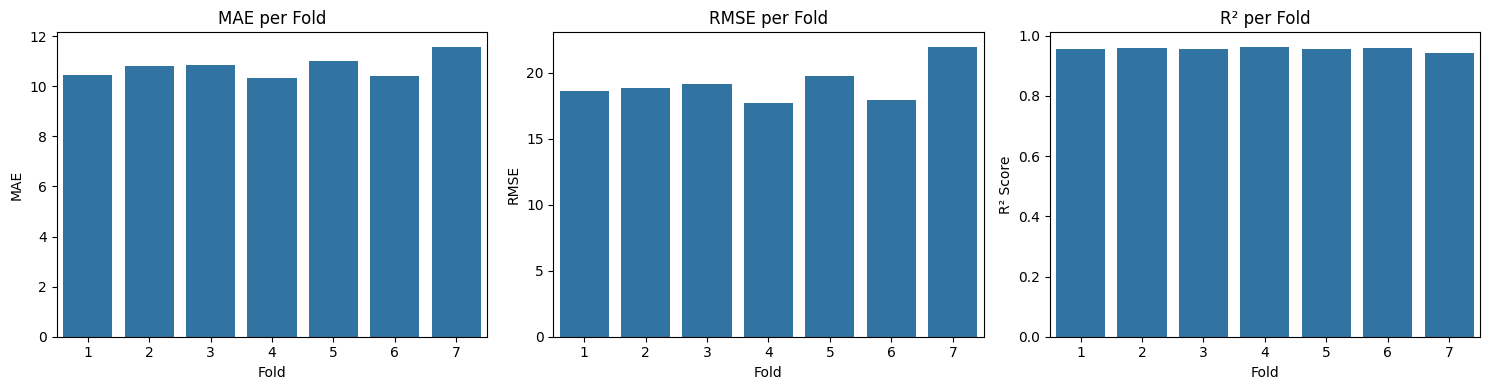

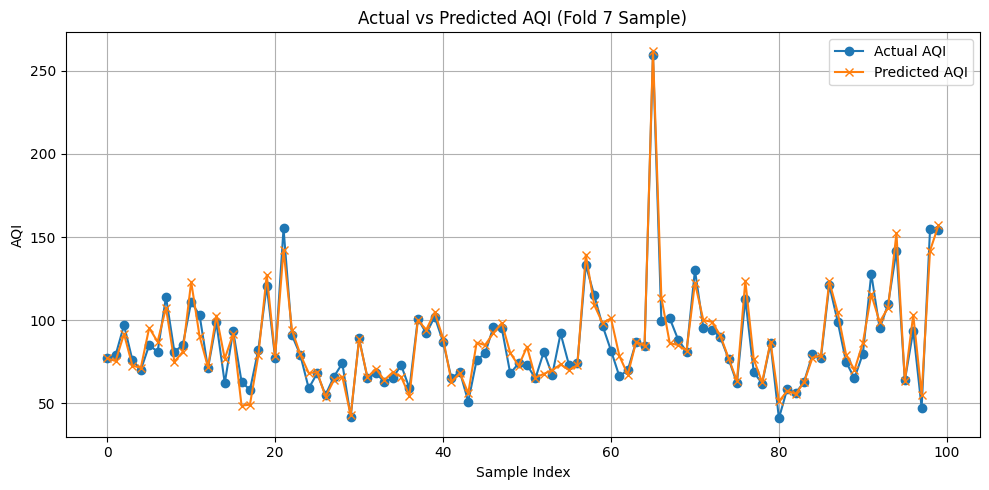

/tmp/ipython-input-8-3845319667.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


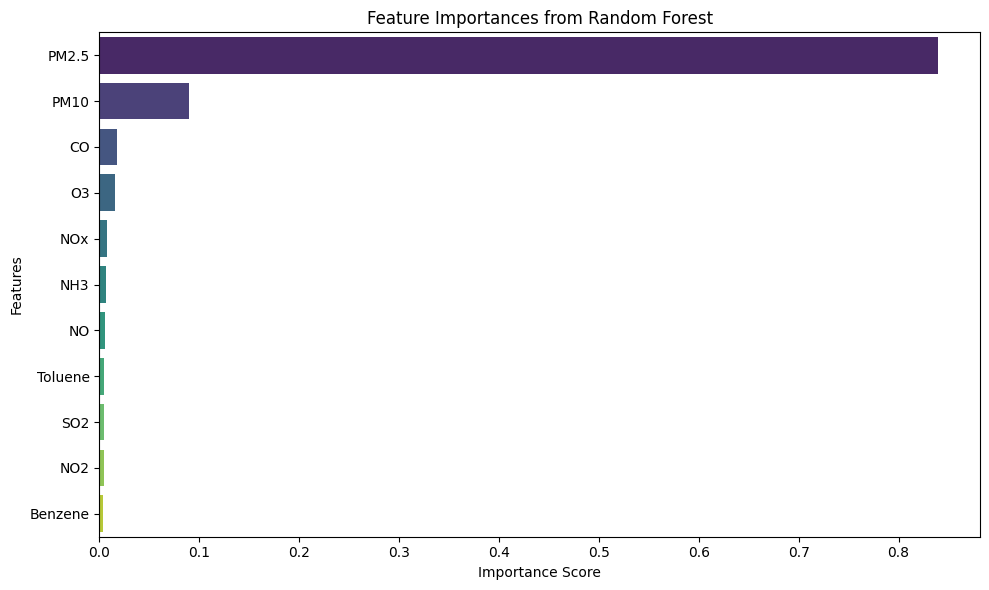

✅ Visualizations generated. Final model saved as 'rf_cv_model.pkl'


In [8]:
# @title ## --- Visualizations ---

# 1. Bar plots of MAE, RMSE, R2 across folds
folds = list(range(1, 8))

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.barplot(x=folds, y=mae_list)
plt.title("MAE per Fold")
plt.xlabel("Fold")
plt.ylabel("MAE")

plt.subplot(1, 3, 2)
sns.barplot(x=folds, y=rmse_list)
plt.title("RMSE per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE")

plt.subplot(1, 3, 3)
sns.barplot(x=folds, y=r2_list)
plt.title("R² per Fold")
plt.xlabel("Fold")
plt.ylabel("R² Score")

plt.tight_layout()
plt.show()

# 2. Actual vs Predicted for last fold
plt.figure(figsize=(10, 5))
plt.plot(all_acts[-1][:100], label="Actual AQI", marker='o')
plt.plot(all_preds[-1][:100], label="Predicted AQI", marker='x')
plt.title("Actual vs Predicted AQI (Fold 7 Sample)")
plt.xlabel("Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Feature Importance
importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("✅ Visualizations generated. Final model saved as 'rf_cv_model.pkl'")

